### Load AG news  + train/dev/test splits

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset

SEED = 10

dataset = load_dataset("sh0416/ag_news")

df_train = pd.DataFrame(dataset['train'])
df_test  = pd.DataFrame(dataset['test'])

print("Train samples:", len(df_train))
print("Test samples: ", len(df_test))

# Make dev from train
df_train, df_dev = train_test_split(
    df_train,
    test_size=0.1,
    random_state=SEED,
    stratify=df_train["label"] # Ensure equally distributed categories across splits
)

print("Train:", len(df_train))
print("Test: ", len(df_test))
print("Dev:  ", len(df_dev))


c:\Users\erik\OneDrive\EStuff\University\yr2\nlp\assignment 1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train samples: 120000
Test samples:  7600
Train: 108000
Test:  7600
Dev:   12000


### Calculate importance of words in articles via TF-IDF

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    lowercase=True, # N
    stop_words='english', # Remove common english words
    ngram_range=(1,1)    # only unigrams
)

# Generate vector form of words
for df in [df_train, df_dev, df_test]:
    df["text"] = df["title"] + " " + df["description"]
X_train = tfidf.fit_transform(df_train['text'])

# Transform words to vector form
X_dev   = tfidf.transform(df_dev['text'])
X_test  = tfidf.transform(df_test['text'])

# Parallel Lists of Category of news articles
y_train = df_train['label']
y_dev   = df_dev['label']
y_test  = df_test['label']


### Logistical Regression Model

In [3]:
# https://chatgpt.com/c/698eee55-0fb8-832f-9408-c060a6dfce49
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

logistic_model = LogisticRegression(
	max_iter = 1000, # Number of steps in gradient descent
	random_state=SEED,
	C=1 # inverse regularization strength against overfitting
)

logistic_model.fit(X_train, y_train)

y_dev_pred_logistic_model = logistic_model.predict(X_dev)

print('Dev set - logistic:')
print('accuracy', accuracy_score(y_dev, y_dev_pred_logistic_model))
print('f1 marco', f1_score(y_dev, y_dev_pred_logistic_model, average='macro'))

Dev set - logistic:
accuracy 0.9208333333333333
f1 marco 0.9206662528666059


### Support Vector Machine
Making a linear svm model

In [4]:
from sklearn.svm import LinearSVC
svm = LinearSVC(
	max_iter=5000,
	random_state=SEED,
	C=1
)
svm.fit(X_train, y_train)

y_dev_pred_svm = svm.predict(X_dev)
print('dev set - linear svm:')
print('accuracy', accuracy_score(y_dev, y_dev_pred_svm))
print('macro f1', f1_score(y_dev, y_dev_pred_svm, average='macro'))

dev set - linear svm:
accuracy 0.9204166666666667
macro f1 0.9202916262589473


Testing Accuracy:
accuracy 0.9136842105263158
f1 macro 0.9134925151464807
              precision    recall  f1-score   support

           1       0.93      0.90      0.92      1900
           2       0.96      0.98      0.97      1900
           3       0.88      0.88      0.88      1900
           4       0.88      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



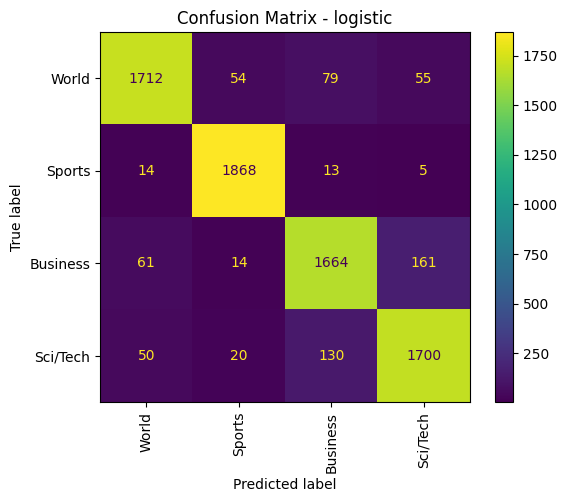

linear svm - test set


In [5]:
y_test_pred_lr = logistic_model.predict(X_test)
print('Testing Accuracy:')
print('accuracy', accuracy_score(y_test, y_test_pred_lr))
print('f1 macro', f1_score(y_test, y_test_pred_lr, average='macro'))
print(classification_report(y_test, y_test_pred_lr))

cm_lr = confusion_matrix(y_test, y_test_pred_lr)
disp_lr = ConfusionMatrixDisplay(cm_lr, display_labels=['World', 'Sports', 'Business', 'Sci/Tech'])
disp_lr.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix - logistic')
plt.show()

y_test_pred_svm = svm.predict(X_test)
print('linear svm - test set')

In [ ]:
label_map = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}

# Copying the test data and add our model's guesses to it.
df_analysis = df_test.copy()
df_analysis["predicted_label"] = y_test_pred_lr

# Grabbing only the rows where the model got it wrong.
errors = df_analysis[df_analysis["label"] != df_analysis["predicted_label"]]

# Checking how many we got wrong in total.
print(f"Total test samples: {len(df_test)}")
print(f"Found {len(errors)} errors.\n")

for i, row in errors.head(20).iterrows():
    print(i, "-" * 50)
    print(f"{row['text']}")
    print(f"True Category: {label_map[row['label']]}")
    print(f"Model Prediction: {label_map[row['predicted_label']]}")



Total test samples: 7600
Found 656 errors.

--- Error Index: 3 ---
Text: Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar.
True Category: Sci/Tech
Model's Prediction: Sports
--------------------------------------------------
--- Error Index: 20 ---
Text: IBM to hire even more new workers By the end of the year, the computing giant plans to have its biggest headcount since 1991.
True Category: Sci/Tech
Model's Prediction: Business
--------------------------------------------------
--- Error Index: 23 ---
Text: Some People Not Eligible to Get in on Google IPO Google has billed its IPO as a way for everyday people to get in on the process, denying Wall Street the usual stranglehold it's had on IPOs. Public bidding, a minimum